# Debugging: why is the ray traced DM map offset from the galaxy map?

In [1]:
import numpy as np
import pandas as pd
import os
from astropy import units as u

import sys
sys.path.append('../')
from illustris_frb import frb_simulation, simulation

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [6]:
from illustris_frb.utils import rotate_to_0, rotate_to_1

In [24]:
np.longdouble(2)

2.0

In [42]:
v = np.array([[1,0,0],
              [5,0,0],
              [10,0,0]])
k = np.array((1,2,3))
np.cross(k, v)

array([[  0,   3,  -2],
       [  0,  15, -10],
       [  0,  30, -20]])

In [44]:
print([np.cross(k, v_) for v_ in v])

[array([ 0,  3, -2]), array([  0,  15, -10]), array([  0,  30, -20])]


In [29]:
phi1s = []
for phi1 in np.arange(0, 2*np.pi, 0.2):
    theta0, phi0 = rotate_to_0(np.pi/2, phi1, 0.1, 0)
    theta1, phi1 = rotate_to_1(theta0, phi0, 0.1, 0)
    phi1s.append(phi1)

(-0.1, 0.1)

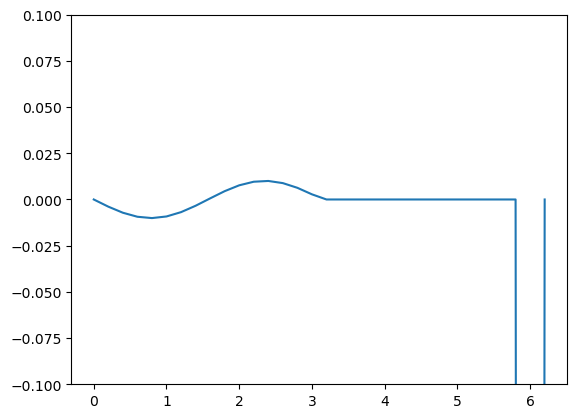

In [32]:
plt.plot(np.arange(0, 2*np.pi, 0.2), np.array(phi1s) - np.arange(0, 2*np.pi, 0.2))
plt.ylim(-0.1,0.1)

(1.7137998874268958, 0.7899346272167872)

In [13]:
np.pi/2

1.5707963267948966

In [2]:
datapath = '/data/submit/submit-illustris/april/data/results'
figpath = '/home/submit/aqc/frb_project/figures'

In [ ]:
sim = simulation('L205n2500TNG')

In [128]:
print((sim.cosmo.kpc_comoving_per_arcmin(0.4)*(0.18*u.rad)).to(u.kpc))
print((sim.boxsize * u.kpc / sim.h))

# laterally we are only looking at one simulation box

287869.20622277487 kpc
302627.69412459404 kpc


In [130]:
print(sim.cosmo.comoving_distance(0.4).to(u.kpc).value / (sim.boxsize / sim.h)) #number of simulation boxes

5.284623314235982


### z=0.2 shell

In [3]:
df = pd.read_hdf(os.path.join(datapath, 'debugshell_z02.hdf5'))
df

,DM,N_g
0,66.708277,132
1,37.090387,79
2,45.686083,67
3,29.519959,55
4,28.181216,48
...,...,...
32395,58.997299,103
32396,101.983362,132
32397,107.614813,115
32398,83.565625,115


In [4]:
shape = np.array((180,180))

DMs = np.array(df['DM']).reshape(shape)
N_gs = (np.array(df['N_g']).reshape(shape) / df['N_g'].mean()) - 1

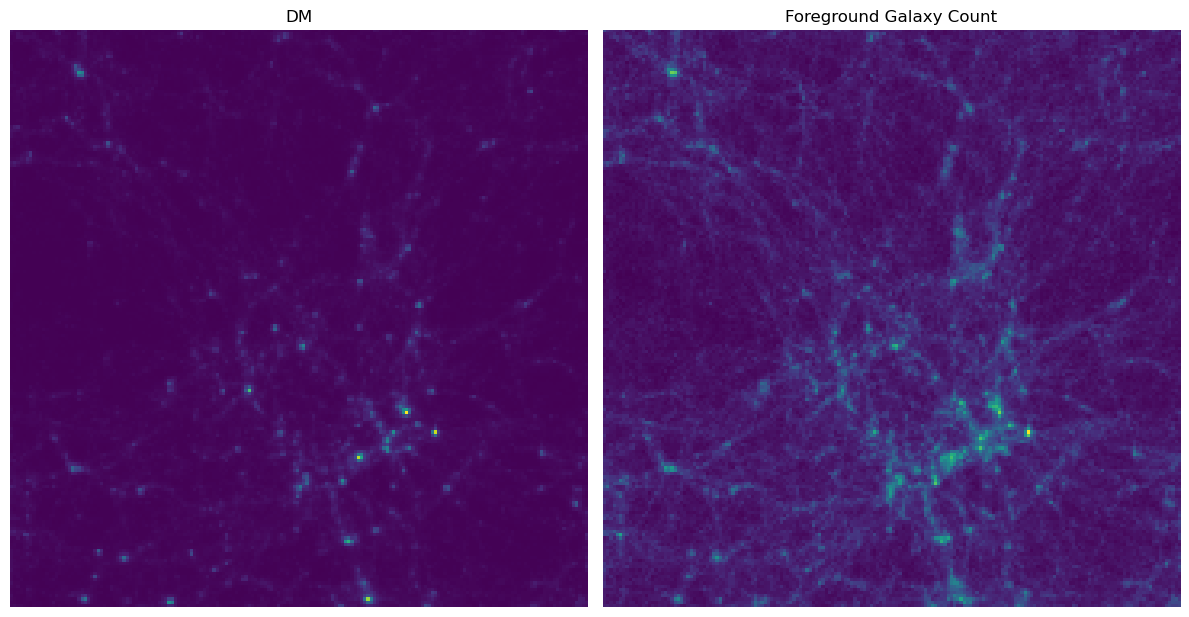

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 20), sharex=True, sharey=True)

axes[0].imshow(DMs)
axes[0].set_title('DM')
axes[0].axis('off')

axes[1].imshow(N_gs)
axes[1].set_title('Foreground Galaxy Count')
axes[1].axis('off')

plt.tight_layout()
# plt.savefig(os.path.join(figpath, 'test_flat_res001_shell_heatmap.png'), bbox_inches='tight')

In [5]:
df[df['DM']<0]

,DM,N_g
5,-14.910758,40
15,-156.070230,66
16,-1156.890194,56
17,-300.669852,35
18,-215.815407,20
...,...,...
32383,-121.580622,104
32384,-2954.921534,114
32391,-13.889238,60
32398,-925.276212,115


## preliminary tests

### electron density map vs counts map

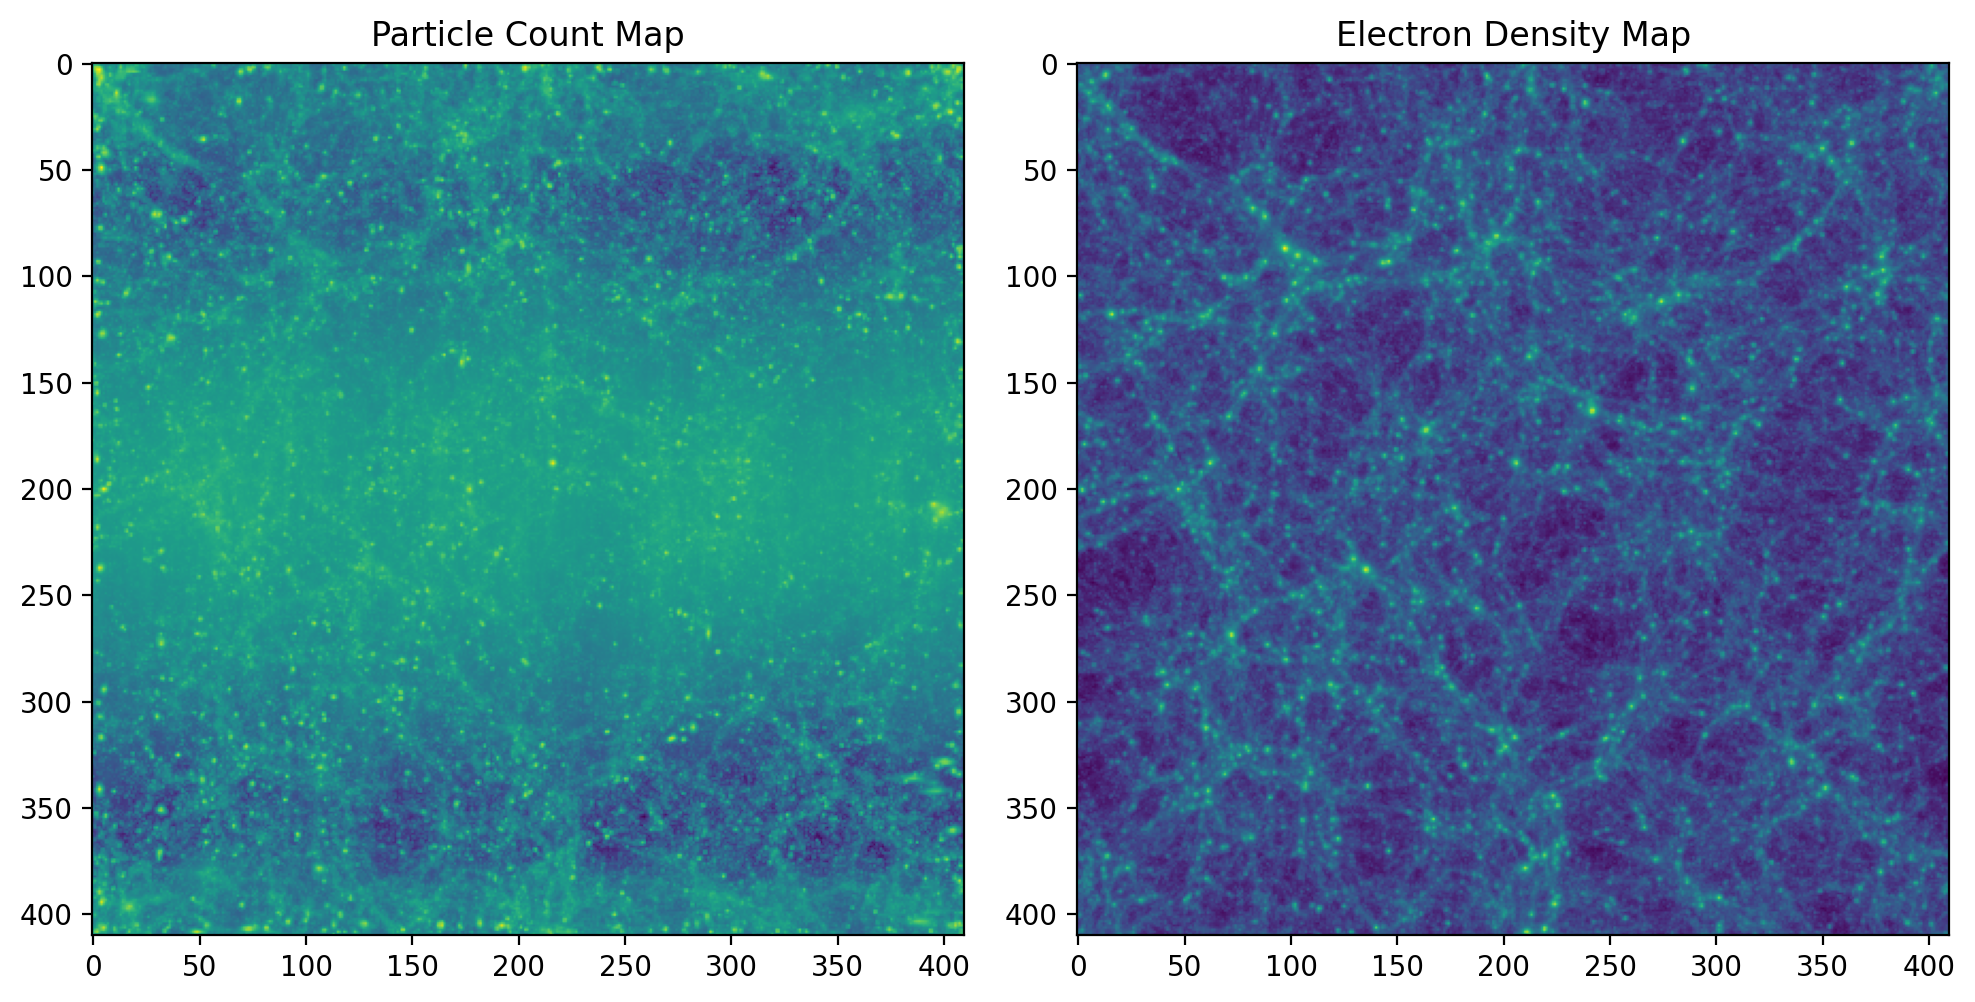

In [1]:
# I had to do this on illustris, but here's the figure

from IPython.display import Image
Image(filename='figures/e_map_comparison.png') 

The electron density map is created correctly 

### electron density map vs ray tracing 

In [4]:
sim = frb_simulation('L205n2500TNG')
N = 50

grid = np.array(np.meshgrid(np.arange(N), np.arange(N))).T.reshape(N**2, 2)
grid = grid*(sim.boxsize/N) + (sim.boxsize/N)/2
grid = np.hstack((grid, np.zeros((N**2, 1))))

In [6]:
DMs = []
for origin in grid:
    sim = frb_simulation('L205n2500TNG', origin=origin)
    dest = origin + np.array([0,0,sim.boxsize])
    DMs.append(sim.get_frb_DM(dest).value)


In [7]:
np.save('debug_DM_grid.npy', np.array(DMs))

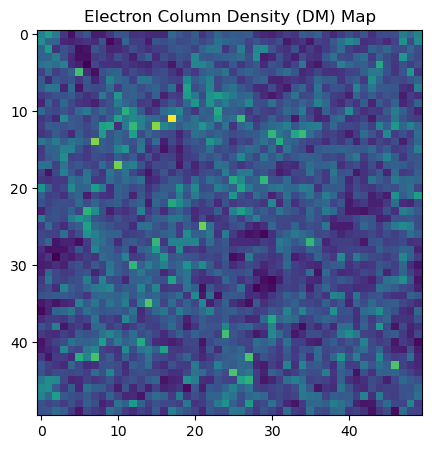

In [9]:
DMs = np.array(DMs).reshape((N,N))
fig = plt.figure(figsize=(5,5))
plt.imshow(DMs, norm=LogNorm())
plt.title('Electron Column Density (DM) Map')
plt.savefig('../figures/DM_map.png', dpi=200)

### Galaxy map 

In [12]:
g_df = pd.read_hdf('../data/g_maps/99_galaxies.hdf5')
g_df

,x,y,z,Mass,SFR,Radius
0,44003.539062,49335.136719,147348.671875,128334.601562,0.0,940.981323
1,45421.101562,51842.078125,146393.109375,36333.289062,0.0,476.462219
2,44488.332031,49092.589844,147870.812500,896.404297,0.0,73.835571
3,43819.976562,50933.199219,147711.140625,494.986298,0.0,75.418587
4,44303.148438,49630.011719,147869.000000,467.464050,0.0,62.782177
...,...,...,...,...,...,...
14435606,199774.828125,105178.773438,117246.093750,0.103569,0.0,10.532459
14435607,196450.437500,9943.825195,184929.953125,0.107553,0.0,10.443684
14435608,197119.390625,130806.460938,128707.078125,0.107553,0.0,6.513499
14435609,203048.328125,5476.173828,41676.285156,0.103569,0.0,8.920770


In [13]:
H, _, _ = np.histogram2d(g_df['x'], g_df['y'], bins=np.arange(0, ))

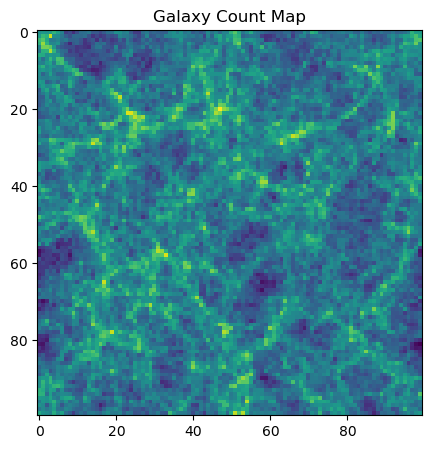

In [15]:
fig = plt.figure(figsize=(5,5))
plt.imshow(H, norm=LogNorm())
plt.title('Galaxy Count Map')
plt.savefig('../figures/N_gal_map.png', dpi=200)